In [1]:
import sys
sys.path

['/share/home/jvmt/CSST/SNPP/chili/1.11alpha/code',
 '/share/home/jvmt/anaconda3_7/lib/python37.zip',
 '/share/home/jvmt/anaconda3_7/lib/python3.7',
 '/share/home/jvmt/anaconda3_7/lib/python3.7/lib-dynload',
 '',
 '/share/home/jvmt/anaconda3_7/lib/python3.7/site-packages',
 '/share/home/jvmt/anaconda3_7/lib/python3.7/site-packages/IPython/extensions',
 '/share/home/jvmt/.ipython']

In [2]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib
import pandas as pd
from scipy import interpolate
import os
from scipy.integrate import simps

## B.1.读取不同波段透光率
## calculate filter

In [3]:
def filteraa(filtera):
    #load the filters          
    filtersel=filtera #'../sdss_g0.par'            
    filterpath='./'
    filterfile=filterpath+filtersel   # ;fluxfilter: max=1, min=0, no particular unit
    print(filterfile)   

    ia=0
    with open(filterfile,'r') as fh:
        for line in fh:
            if line.startswith('#'):
                ia=ia+1
                continue

    band=pd.read_csv(filterfile,sep='\s+',header=None,skiprows=ia)
    wavefilter=np.array(band[0])
    fluxfilter=np.array(band[1])
    wavefilter=wavefilter  # A
    vmin=wavefilter[0]
    vmax=wavefilter[-1]

    # find the central wavelength, effective wavelength, and FWHM of the given filter
    filtermid=(vmax-vmin)*0.5  #A, central wavelength
    dwave=wavefilter[1:]-wavefilter[:-1]
    filtereff=np.nansum(dwave*wavefilter[1:]*fluxfilter[1:])/np.nansum(dwave*fluxfilter[1:]) #A, effective wavelength
    rmax=np.max(fluxfilter)
    nnn=np.where(fluxfilter > 0.5*rmax)[0]
    FWHMmin=wavefilter[nnn[0]]
    FWHMmax=wavefilter[nnn[-1]]
    filterwid=FWHMmax-FWHMmin  #A, FWHM

    return wavefilter,fluxfilter,vmin,vmax,filtereff,FWHMmin,FWHMmax

## B.2.采用我们提供的模板，生成适应CSST-IFU波长流量
## input_mag_model

In [40]:
#select input parameters
def input_mag_model(targetmag,galtpl,filtera,dlambda,a,b):

    #filter
    resulte=filteraa(filtera)
    wavefilter=resulte[0]
    fluxfilter=resulte[1]
    vmin=resulte[2]
    vmax=resulte[3]
    filtereff=resulte[4]

    ####################################################################################
    # define wavelength array,
    #cover the range of 350nm to 1050nm, depend on the spectral resolution wanted. 

    delta_lambda=dlambda # has to be in unit of A
    print('delta_lambda:', delta_lambda)
    
    narray=int((b-a)/delta_lambda) 
    wavearr=a+delta_lambda*np.float64(np.arange(narray))
    
    # select out the array of V band filter
    nar=int((10000-3500)/delta_lambda) 
    wavearr1=3500+delta_lambda*np.float64(np.arange(nar))
    
    ii=np.logical_and(wavearr1 >= vmin, wavearr1 <= vmax)
    wavetmp2=wavearr1[ii]
    x=np.interp(wavetmp2,wavefilter,fluxfilter)
    integratef4=x*wavetmp2
    integconst=simps(integratef4,wavetmp2) # int(lambda*Rlambda*dlambda)

    lambdav=filtereff #A
    ###############################################################
    # define basic target brightness, parameters constantly change
    itarget=targetmag    # in Johnson V mag/arcsec^2 unit
    print('itarget:',itarget)

    itarget_jy=3631.0*10**(-itarget/2.5+3.0)  # target flux in V in mJy/arcsec^2 unit
    itarget_nm=itarget_jy*3.0/(lambdav/100.0)**2 #target flux in V in 10^(-12)erg/s/cm^2/A/arcsec^2 

    tplfile=galtpl
    print('tplfile:',tplfile)   

    sfgal=fits.open(tplfile)
    wavegal=sfgal[1].data['wavelength'] # A
    galflux2=sfgal[1].data['flux']
    galflux1=np.interp(wavearr1,wavegal,galflux2)

    #;normalize the galaxy spectrum to the V band magnitude specified.
    ii=np.logical_and(wavegal >= vmin, wavegal <= vmax)
    wavetmp=wavegal[ii]
    fluxtmp=galflux2[ii]
    x=np.interp(wavetmp,wavefilter,fluxfilter)
    vfluxtmp=x*wavetmp*fluxtmp #bandpass*lambda*F_gal_lambda
    galintegrate=simps(vfluxtmp,wavetmp)
    galnorm=itarget_nm*integconst/galintegrate
    galflux1=galnorm*galflux1   # the unit should now be in 10^(-12)erg/s/A/cm^2/arcsec^2 
    
    #galflux=np.interp(wavearr,wavearr1,galflux1)
    galflux=galflux1
    
    return wavearr, galflux, wavearr1

## B.3.采用自己提供谱型流量的方式，生成适应CSST-IFU波长流量 
## input_wave_flux

In [41]:
# select put in wave and flux
def input_wave_flux(wave,flux,dlambda):

    wave=wave
    flux=flux
    delta_lambda=dlambda
    narray=int((wave[-1]-wave[0])/delta_lambda) 
    wavearr=wave[0]+delta_lambda*np.float64(np.arange(narray))

    galflux=np.interp(wavearr,wave,flux)      #erg/s/A/cm2/arcsec^2

    return wavearr, galflux*10**12    #10^(-12)erg/s/A/cm^2/arcsec^2


## B.4. 输入模板参数，生成波长流量

In [73]:
targetmag=21.438  #mag/arcsec2
galtpl='../obs/SFgal_tpl/SFgal_texp_FeH-2_tau10_Ew50.fits'
filtera='../obs/filters/sdss_g0.par'

result=input_mag_model(targetmag,galtpl,filtera,0.98,3490.71,5500.)
wavearr=result[0]   #A
galflux=result[1]   #10^-12 erg/s/A/cm2   


'''
filee=fits.open('/usr/local/ifspip/CSSTMock-NGC10-FOV10R0.1.fits')
fil=filee[1].data[20:80,20:80]
fluxx=fil[30,30,:]*100*10**-17  #erg/s/A/cm2/arcsec2 
wavee=filee[2].data    #A

result=input_wave_flux(wavee,fluxx)
wavearr=result[0]  #A
galflux=result[1]  #10^-12 erg/s/A/cm2/arcsec2
'''

./../obs/filters/sdss_g0.par
delta_lambda: 0.98
itarget: 21.438
tplfile: ../obs/SFgal_tpl/SFgal_texp_FeH-2_tau10_Ew50.fits


"\nfilee=fits.open('/usr/local/ifspip/CSSTMock-NGC10-FOV10R0.1.fits')\nfil=filee[1].data[20:80,20:80]\nfluxx=fil[30,30,:]*100*10**-17  #erg/s/A/cm2/arcsec2 \nwavee=filee[2].data    #A\n\nresult=input_wave_flux(wavee,fluxx)\nwavearr=result[0]  #A\ngalflux=result[1]  #10^-12 erg/s/A/cm2/arcsec2\n"

In [74]:
len(galflux)

6632

## B.5. 可调节参数

In [75]:
readnoise=5.5
fovp=3.2
npixel_width=5.0
obstime=300
repeatnum=20.0
skyr=21.0
qinput=0.05
specsample=1.0
snlimit=10.0

## B.6.不可调节参数

In [76]:
#some basic unchanged parameters     
d=240        # diameter of the telescope, in cm unit
obscure=0.1  #effective central obscuration, no unit
telarea=3.14159/4.0*d*d*(1.0-obscure)  #effective area of the telescope, cm^2
darkc=0.017   #dark current, in e/s/pix
planckh=6.626    # 10^{-27} erg*s
cc=3.0   # speed of light, 10^{18} A/s
#slitunit=0.074  # arcsec. the length of slit which conresponds to a pixel length on IFU CCD 

rn=readnoise  #read noise, in e/pix
print('readnoise:', rn)

npixw=npixel_width
print('npixel_width:',npixw)

obst=obstime  # in seconds, single integration time
print('obstime:',obst)

repn=repeatnum   # repeating time
print('repeatnum:',repn)

iskyr0=skyr  # in Johnson V mag/arcsec^2 unit
print('skyv:', iskyr0)

sampling=1.0
#print('specsample:',sampling)

delta_lambda=0.98


readnoise: 5.5
npixel_width: 5.0
obstime: 300
repeatnum: 20.0
skyv: 21.0


## B.7. 其他参数

In [77]:
# some less basic parameters, may change, but not often

#throughput=0.05
#lambdaq=np.array(throughput[0])*10 # A
qtot=0.1 #; throughput of the whole system,


#;assuming the total throughput cannot reach the theory value, 0.3 is the upper limit. 
#qtot[qtot>=0.3]=0.3 

qinput=qinput
print('qinput:', qinput)

q=qtot*qinput #*qe ;qtot of CSST already includes the CCD efficiency 
print('q:',q)

fov2=((fovp)**2)*3.14159/4.0
print('fov2:', fov2)             

qinput: 0.05
q: 0.005000000000000001
fov2: 8.042470400000001


## B.8.天光计算

In [78]:
resulte=filteraa('../obs/filters/sdss_r0.par')
wavefilter=resulte[0]
fluxfilter=resulte[1]
vmin=resulte[2]
vmax=resulte[3]
filtereff=resulte[4]
FWHMmin = resulte[5]
FWHMmax = resulte[6]

# select out the array of r band filter
nar=int((10000-3500)/delta_lambda) 
wavearr1=3500+delta_lambda*np.float64(np.arange(nar))

ii=np.logical_and(wavearr1 >= vmin, wavearr1 <= vmax)

wavetmp2=wavearr1[ii]
x=np.interp(wavetmp2,wavefilter,fluxfilter)
integratef4=x*wavetmp2    
integconst=simps(integratef4,wavetmp2) # int(lambda*Rlambda*dlambda)

#####################

#define r band sky brightness
lambdar=filtereff   #in A

#sky brightness corresponding to this sky magnitude
iskyr0_jy=3631.0*10**(-iskyr0/2.5+3.0)  # sky flux in V in mJy/arcsec^2 unit
iskyr0_nm=iskyr0_jy*3.0/(lambdar/100.0)**2 #sky flux in V in 10^(-12)erg/s/cm^2/A /arcsec^2 

#readin the ground sky spectrum 
skybg_50=pd.read_csv('../obs/skybg_50_10.dat',sep='\s+',header=None,skiprows=14)
wavesky=np.array(skybg_50[0])*10 #in A
fluxsky1=np.array(skybg_50[1])/10 #phot/s/A/arcsec^2/m^2
fluxsky2=fluxsky1/wavesky*1.98 #change the sky flux unit to 10^(-12)erg/s/cm^2/A/arcsec^2


#This fluxsky is in unit of phot/s/A/arcsec^2/m^2, to convert it to F_lambda/arcsec^2, 
#need to do fluxsky(phot/s/A/arcsec^2/m^2)*h(6.625*10^{-27}erg.s)*nu(1/s)*10{-4}(m^2/cm^2)
#=fluxsky*c(3.0*10^{18}A/s)/lambda(A)*6.6*10{-31} erg/s/cm^2/A/arcsec^2
#=fluxsky/lambda*1.98*10^{-12}erg/s/cm^2/A/arcsec^2 

#find out the normalization of the sky,
ii=np.logical_and(wavesky >= vmin, wavesky <= vmax)
wavetmp=wavesky[ii]
fluxtmp=fluxsky1[ii]

x=np.interp(wavetmp,wavefilter,fluxfilter)
vfluxtmp=x*fluxtmp*1.98  #bandpass*lambda*F_sky_lambda(fluxsky2)=bandpass*fluxsky*1.98
skyintegrate=simps( vfluxtmp ,wavetmp)
skynorm=iskyr0_nm*integconst/skyintegrate 
fluxsky3=np.interp(wavearr1,wavesky,fluxsky2)
fluxsky4=fluxsky3*skynorm   
# get the sky spectrum in wavearr grid, the unit should now be the same as fluxvega: 10^(-12) erg/s/A/cm^2/arcsec^2 

#fluxskypp=np.interp(wavearr,wavearr1,fluxsky4)                
fluxskypp=fluxsky4


./../obs/filters/sdss_r0.par


## B.9.生成噪声

In [79]:
#define observation information, parameters constantly change

narray=len(wavearr1)
snarray=np.zeros(narray)
mockgal=np.zeros(narray)
expf2=np.zeros(narray)
tmp=np.zeros(narray)
tot_noise1=np.zeros(narray*2).reshape(narray,2)
sc_noise1=np.zeros(narray*2).reshape(narray,2)
sys_noise1=np.zeros(narray*2).reshape(narray,2)
readnoise1=np.zeros(narray*2).reshape(narray,2)
dark_noise1=np.zeros(narray*2).reshape(narray,2)
sky_noise1=np.zeros(narray*2).reshape(narray,2)

for i in range(narray):
    lambda0=wavearr1[i]
    qlambda=q
    hv=planckh*cc/lambda0 #;10^{-9}erg
    delta_hz=cc*delta_lambda/lambda0/lambda0 #;10^18 1/s
    delta_shz=delta_hz*sampling

    #now that many fluxes are in 10^(-12)erg/s/A/cm^2/arcsec^2 , to convert it to Jy, need to multiple: 
    #lambda0^2/c(in A)=lambda0^2(A)/(3.*10^(18))*10^(-12)erg/s/Hz/cm^2
    #=lambda^2(A)*3.33*10^(-31)erg/s/Hz/cm^2=lambda^2(A)*3.33*10^(-8)Jy
    #=lambda^2(A)*0.0333uJy/arcsec^2 

    #find out sky value at lambda0    
    #calculate n_sky/pixel
    isky=fluxskypp[i]*lambda0**2*0.0333*fov2   #in uJy/spaxel unit
    iskyall=isky*telarea/1000.0   #in 10-26 erg/s/Hz /spaxel
    fsky=qlambda*iskyall*delta_hz   #10^{-8} erg/s /spaxel
    fsky=fsky*sampling
    nsky=fsky/hv*10.0   #in unit of #e/s /spaxel

    #calculate n_source/pixel
    isource=galflux[i]*lambda0**2*0.0333*fov2   #in uJy/spaxel unit
    isall=isource*telarea/1000.0   #in 10-26 erg/s/Hz /spaxel
    fs=qlambda*isall*delta_hz   #10^{-8} erg/s /spaxel
    fs=fs*sampling
    ns=fs/hv*10.0   #in unit of #e/s /spaxel

    darkn=(darkc*repn*obst*npixw*sampling)
    rnn2=rn**2*(repn*npixw*sampling)
    sourcenn=(ns*repn*obst)
    skynn=(nsky*repn*obst)
    tmp[i]=skynn

    nn1=np.sqrt(rnn2+darkn+skynn+sourcenn)  #total noise
    sn1=repn*ns*obst/nn1  #S/N
    snarray[i]=sn1
    nn=np.sqrt(rnn2+darkn+skynn)  #system noise


    mockgal[i]=(galflux[i]+galflux[i]/snarray[i]*np.random.randn(1,1)[0][0])*fov2  #in 10^{-12} erg/s/A/cm^2

    #in [i,0]-->e/s [i:1]-->10^{-12} erg/s/A/cm^2
    tot_noise1[i,0]=nn1
    tot_noise1[i,1]=(nn1/10*hv/sampling/delta_hz/qlambda/telarea*1000/lambda0**2/0.0333)/repn/obst
    
    sc_noise1[i,0]=np.sqrt(sourcenn)
    sc_noise1[i,1]=(np.sqrt(sourcenn)/10*hv/sampling/delta_hz/qlambda/telarea*1000/lambda0**2/0.0333)/repn/obst
    
    sys_noise1[i,0]=nn
    sys_noise1[i,1]=(nn/10*hv/sampling/delta_hz/qlambda/telarea*1000/lambda0**2/0.0333)/repn/obst
    
    readnoise1[i,0]=np.sqrt(rnn2)
    readnoise1[i,1]=(np.sqrt(rnn2)/10*hv/sampling/delta_hz/qlambda/telarea*1000/lambda0**2/0.0333)/repn/obst
    
    dark_noise1[i,0]=np.sqrt(darkn)
    dark_noise1[i,1]=(np.sqrt(darkn)/10*hv/sampling/delta_hz/qlambda/telarea*1000/lambda0**2/0.0333)/repn/obst
    
    sky_noise1[i,0]=np.sqrt(skynn)
    sky_noise1[i,1]=(np.sqrt(skynn)/10*hv/sampling/delta_hz/qlambda/telarea*1000/lambda0**2/0.0333)/repn/obst

    #set the detection limit 
    detlimit=snlimit

    nntmp=detlimit**2+np.sqrt(detlimit**4+4.0*detlimit**2*nn**2)
    nntmp=nntmp/2.0            
    #calculate detection limit in uJy and mag
    fnn=nntmp
    f1=fnn/obst/repn    #in e/s
    f2=f1*hv       #in 10^{-9} erg/s
    f3=f2/delta_lambda #in 10^{-9} erg/s/A
    f1=f3/telarea #in 10^{-9} erg/s/A/cm^2
    f2=f1/qlambda    #in 10^{-9} erg/s/A/cm^2
    expf2[i]=f2/fov2*100000.   # in 10^{-14} erg/s/A/cm^2/arcsec^2

In [80]:
def proda(aaa,bbb):

    bbb=np.zeros(len(wavearr)*2).reshape(len(wavearr),2)
    bbb[:,0]=np.interp(wavearr,wavearr1,aaa[:,0]) 
    bbb[:,1]=np.interp(wavearr,wavearr1,aaa[:,1])
    
    return bbb

In [81]:
lambda1=wavearr
snarray=np.interp(wavearr,wavearr1,snarray)
galflux=(np.interp(wavearr,wavearr1,galflux))*fov2 
tot_noise=proda(tot_noise1,tot_noise)
sc_noise=proda(sc_noise1,sc_noise)           
sys_noise=proda(sys_noise1,sys_noise)
readnoise=proda(readnoise1,readnoise)
dark_noise=proda(dark_noise1,dark_noise)
sky_noise=proda(sky_noise1,sky_noise)
mockgal=np.interp(wavearr,wavearr1,mockgal) 

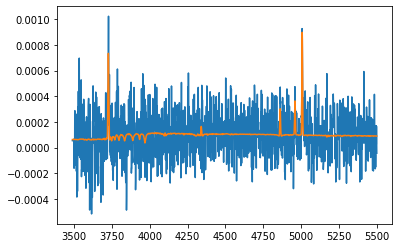

In [82]:
plt.plot(wavearr,mockgal)
plt.plot(wavearr,galflux)

In [83]:
tot_noise.shape

(2050, 2)

In [ ]:
filename='../results/crab_30020_blue.fits'
# write file
unit=np.array(['A', ' ','1E-12 erg/s/cm^2/A',\
               'e/s & 1E-12 erg/s/cm^2/A','e/s & 1E-12 erg/s/cm^2/A','e/s & 1E-12 erg/s/cm^2/A',\
               'e/s & 1E-12 erg/s/cm^2/A','e/s & 1E-12 erg/s/cm^2/A','e/s & 1E-12 erg/s/cm^2/A', \
               '1E-12 erg/s/cm^2/A'])

hdr=fits.Header()
for i in range(len(unit)):
    hdr[str(i)]=unit[i]
hun1=fits.PrimaryHDU(header=hdr)
hun2=fits.ImageHDU(wavearr,name='lambda')
hun3=fits.ImageHDU(snarray,name='S/N')
hun4=fits.ImageHDU(galflux,name='tar_flux')
hun5=fits.ImageHDU(tot_noise,name='tot_noise')
hun6=fits.ImageHDU(sc_noise,name='sc_noise')
hun7=fits.ImageHDU(sys_noise,name='sys_noise')
hun8=fits.ImageHDU(readnoise,name='readnoise')
hun9=fits.ImageHDU(dark_noise,name='dark_noise')
hun10=fits.ImageHDU(sky_noise,name='sky_noise')
hun11=fits.ImageHDU(mockgal,name='mockgal')
hdulist = fits.HDUList([hun1,hun2,hun3,hun4,hun5,hun6,hun7,hun8,hun9,hun10,hun11])

print('output filt:',filename)
hdulist.writeto('./'+filename)